# ModelV2
Improves of V1 by taking G-Buffers as input and G-buffer feature extractor.

In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from config import Settings, device
from network.modules.feature_extractors import HRGBufferFeatureExtractor, LRFrameFeatureExtractor
from network.modules.reconstruction_modules import FeatureFusion
from utils.image_utils import ImageUtils
from network.dataset import WDSSDatasetCompressed, GB_Type
from utils.wavelet import WaveletProcessor

from typing import List, Tuple, Union

# Model

In [3]:
class WDSSV3(nn.Module):
    def __init__(self):
        super(WDSSV3, self).__init__()

        self.upscale_factor = 2
        self.hr_gbuffer_feature_extractor = HRGBufferFeatureExtractor(48, 32, [64, 64, 64, 64])
        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 32, [32, 32])
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])

    def forward(self, lr_frame: torch.Tensor, hr_gbuffers: torch.Tensor) -> torch.Tensor:
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffers, 2)

        lr_frame_features = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        
        lr_frame_wavelet = WaveletProcessor.batch_wt(lr_frame)
        
        lr_frame_wavelet_upsampled = F.interpolate(lr_frame_wavelet, scale_factor=self.upscale_factor, mode='nearest')
        
        # Upsample the low resolution frame features
        lr_frame_features_upsampled = F.interpolate(lr_frame_features, scale_factor=self.upscale_factor, mode='nearest')
        
        hr_gbuffers_features = self.hr_gbuffer_feature_extractor(hr_gbuffers_pixel_unshuffled)
        
        # Concatenate the features
        features = torch.cat((lr_frame_features_upsampled, hr_gbuffers_features), dim=1)
        
        # Fuse the features
        fused_features = self.feature_fusion(features)
        
        # Elementwise sum the fused features and the upsampled wavelet
        # final_wavelet = fused_features + lr_frame_wavelet_upsampled
        final_wavelet = fused_features
        
        return final_wavelet
        # Inverse wavelet transform the final wavelet
        # inverse_wavelet_output = WaveletProcessor.batch_iwt(final_wavelet)

        # return inverse_wavelet_output

    def forward_with_iwt(self, lr_frame: torch.Tensor, hr_gbuffers: torch.Tensor) -> torch.Tensor:
        final_wavelet = self.forward(lr_frame, hr_gbuffers)
        inverse_wavelet_output = WaveletProcessor.batch_iwt(final_wavelet)
        return inverse_wavelet_output


# Dataset

In [4]:
dataset_folder = Settings.dataset_path

dataset = WDSSDatasetCompressed('D:\\Dev\\MinorProjDataset\\V2\\train', 120)
test = dataset[0]
print(test['LR'].shape)
print(test['HR'].shape)
print(len(dataset))

torch.Size([3, 360, 640])
torch.Size([3, 720, 1280])
120


In [5]:
# Model
model = WDSSV3().to(device)

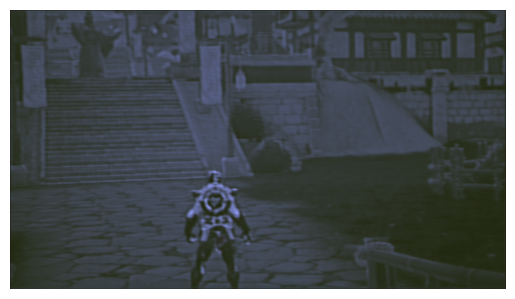

In [22]:
model.eval()
with torch.no_grad():
    res = model.forward_with_iwt(dataset[0]['LR'].unsqueeze(0).to(device), dataset[0]['GB'].unsqueeze(0).to(device))
    ImageUtils.display_image(res.cpu())

In [20]:
# Training Loop
import threading
from network.losses import CriteronSSIM_LPIPS, CriteronMSE_SSIM, CriteronMSE
from utils.pytorch_ssim import SSIM, ssim

# Criterion is combination of MSE and SSIM
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()

    def forward(self, output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        mse_loss = F.mse_loss(output, target)
        return mse_loss

criterion = CriteronSSIM_LPIPS(0.6, 0.4, 12)
criterion2 = CriteronMSE_SSIM(0.8, 12)
criterion3 = CriteronMSE()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
epochs = 10
epoch_loss: float = 0

In [25]:
epochs = 30
epoch_loss: float = 0

def do_nothing():
    ...

def train(i, batch):
    global epoch_loss
    lr_frames = batch['LR'].to(device)
    hr_gbuffers = batch['GB'].to(device)
    hr_frames = batch['HR'].to(device)

    optimizer.zero_grad()

    output = model(lr_frames, hr_gbuffers)
    wavelet_hr = WaveletProcessor.batch_wt(hr_frames).to(device)
    loss = criterion2(output, wavelet_hr)
    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    print(f"Batch {i}, Loss: {loss.item()}")

threadu = threading.Thread(target=do_nothing)
threadu.start()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(dataloader):
        # print("Data loading completed")

        # Wait for the previous batch to finish
        if threadu.is_alive():
            threadu.join()

        # print(f"Batch {i} started")

        # Start the training process
        threadu = threading.Thread(target=train, args=(i, batch))
        threadu.start()
    
    if threadu.is_alive():
        threadu.join()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

# Save the model
torch.save(model.state_dict(), "model/WDSSV3.1.pth")
    


Batch 0, Loss: 0.021846147254109383
Batch 1, Loss: 0.014964064583182335
Batch 2, Loss: 0.01594731956720352
Batch 3, Loss: 0.012731987051665783
Batch 4, Loss: 0.017883066087961197
Batch 5, Loss: 0.016381794586777687
Batch 6, Loss: 0.013698365539312363
Batch 7, Loss: 0.01674262247979641
Batch 8, Loss: 0.014883747324347496
Batch 9, Loss: 0.013441444374620914
Batch 10, Loss: 0.018113959580659866
Batch 11, Loss: 0.014780128374695778
Batch 12, Loss: 0.013936040922999382
Batch 13, Loss: 0.01529761590063572
Batch 14, Loss: 0.01569635048508644
Epoch: 0, Loss: 0.3627958297729492
Batch 0, Loss: 0.015391130931675434
Batch 1, Loss: 0.01358821801841259
Batch 2, Loss: 0.01475803554058075
Batch 3, Loss: 0.016072509810328484
Batch 4, Loss: 0.015527443028986454
Batch 5, Loss: 0.014514897018671036
Batch 6, Loss: 0.016165930777788162
Batch 7, Loss: 0.01412784680724144
Batch 8, Loss: 0.012716701254248619
Batch 9, Loss: 0.01263992115855217
Batch 10, Loss: 0.013882574625313282
Batch 11, Loss: 0.0125959720462

In [9]:
# Save the model
torch.save(model.state_dict(), "model/WDSSV3.1.pth")

In [10]:
# Load the model
model.load_state_dict(torch.load("model/WDSSV3.1.pth"))

C:\Users\Prateek\AppData\Local\Temp\ipykernel_12104\2758956771.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/WDSSV3.1.pth"))


<All keys matched successfully>

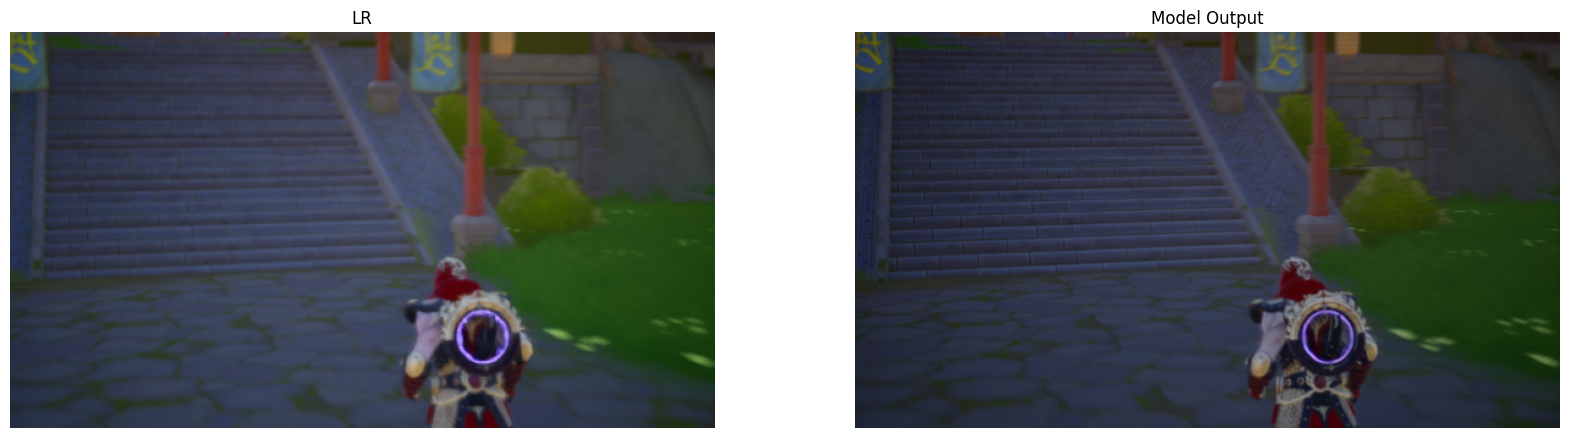

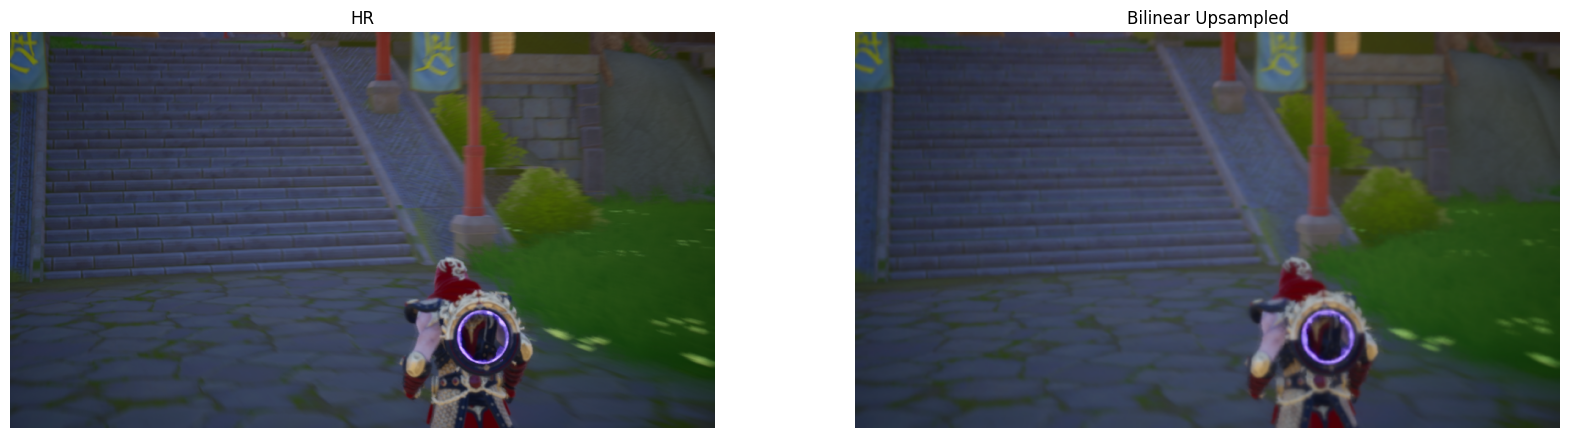

Model MSE: 0.00018188254034612328, Bilinear MSE: 0.0003483629261609167
Model PSNR: 39.151893615722656, Bilinear PSNR: 34.579681396484375
Model SSIM: 0.9795336127281189, Bilinear SSIM: 0.9463400840759277
Model LPIPS: 0.08280330151319504, Bilinear LPIPS: 0.18910208344459534


In [30]:
from network.losses import ImageEvaluator

# Compare the models output with bilinear upsampled output
frame_no = 60

model.eval()
with torch.no_grad():
    res = model.forward_with_iwt(dataset[frame_no]['LR'].unsqueeze(0).to(device), dataset[frame_no]['GB'].unsqueeze(0).to(device))
    binilear_upsampled = F.interpolate(dataset[frame_no]['LR'].unsqueeze(0), scale_factor=2, mode='bilinear')
    ImageUtils.display_images([dataset[frame_no]['LR'].unsqueeze(0) ,res.cpu()],
                              ["LR", "Model Output"])
    ImageUtils.display_images([dataset[frame_no]['HR'].unsqueeze(0), binilear_upsampled],
                              ["HR", "Bilinear Upsampled"])

# Compare the error between the models output and bilinear upsampled output
# model_error = F.mse_loss(res.cpu(), dataset[frame_no]['HR'].unsqueeze(0))
# bilinear_error = F.mse_loss(binilear_upsampled, dataset[frame_no]['HR'].unsqueeze(0))
model_mse = ImageEvaluator.mse(res, dataset[frame_no]['HR'].unsqueeze(0).to(device))
bilinear_mse = ImageEvaluator.mse(binilear_upsampled.to(device), dataset[frame_no]['HR'].unsqueeze(0).to(device))

model_psnr = ImageEvaluator.psnr(res, dataset[frame_no]['HR'].unsqueeze(0).to(device))
bilinear_psnr = ImageEvaluator.psnr(binilear_upsampled.to(device), dataset[frame_no]['HR'].unsqueeze(0).to(device))

model_ssim = ImageEvaluator.ssim(res, dataset[frame_no]['HR'].unsqueeze(0).to(device))
bilinear_ssim = ImageEvaluator.ssim(binilear_upsampled.to(device), dataset[frame_no]['HR'].unsqueeze(0).to(device))

model_lpips = ImageEvaluator.lpips(res, dataset[frame_no]['HR'].unsqueeze(0).to(device))
bilinear_lpips = ImageEvaluator.lpips(binilear_upsampled.to(device), dataset[frame_no]['HR'].unsqueeze(0).to(device))

print(f"Model MSE: {model_mse.item()}, Bilinear MSE: {bilinear_mse.item()}")
print(f"Model PSNR: {model_psnr.item()}, Bilinear PSNR: {bilinear_psnr.item()}")
print(f"Model SSIM: {model_ssim.item()}, Bilinear SSIM: {bilinear_ssim.item()}")
print(f"Model LPIPS: {model_lpips.item()}, Bilinear LPIPS: {bilinear_lpips.item()}")



In [12]:
from network.loss import ImageComparator

In [28]:
import torch
from skimage.metrics import structural_similarity as ssim

# Ensure both tensors are in the same shape and type
hr_image = dataset[frame_no]['HR'].unsqueeze(0)  # Ensure batch dimension added if required
model_image = res.cpu()

# Remove batch dimension
model_image = model_image.squeeze(0)  # Shape becomes (3, 720, 1280)
hr_image = hr_image.squeeze(0)        # Shape becomes (3, 720, 1280)

# Convert to numpy
ssim = ImageComparator.ssim(hr_image, model_image)
psnr = ImageComparator.psnr(hr_image, model_image)

print(f"SSIM: {ssim}, PSNR: {psnr}")

ImageComparator.compare_images(hr_image, model_image)


SSIM: 0.958622932434082, PSNR: 36.482181549072266
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


c:\Dev\MinorProject\WDSS\.venv\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='

Comparison results for unnamed images:
PSNR: 36.48
SSIM: 0.9586
LPIPS: 0.0257


{'psnr': 36.482181549072266,
 'ssim': 0.95862293,
 'lpips': 0.025696078315377235,
 'img1_features': [tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.2386, 0.0000,  ..., 0.0000, 0.0000, 0.4705],
            [0.0000, 0.3280, 0.0000,  ..., 0.0572, 0.0000, 0.6494],
            ...,
            [0.0000, 0.3095, 0.0269,  ..., 0.0441, 0.0000, 0.2620],
            [0.0000, 0.3200, 0.0506,  ..., 0.1023, 0.0000, 0.3578],
            [0.0000, 0.5403, 0.3452,  ..., 0.3294, 0.0000, 0.5808]],
  
           [[0.1409, 0.0000, 0.0000,  ..., 0.0000, 0.0201, 0.0000],
            [0.2936, 0.0000, 0.0000,  ..., 0.0000, 0.2354, 0.0000],
            [0.1826, 0.0000, 0.0000,  ..., 0.0000, 0.1758, 0.0000],
            ...,
            [0.1890, 0.0000, 0.0000,  ..., 0.0000, 0.1351, 0.0000],
            [0.4183, 0.0584, 0.0000,  ..., 0.0000, 0.5127, 0.0000],
            [0.3058, 0.0840, 0.0000,  ..., 0.0000, 0.3694, 0.0000]],
  
           [[0.0000, 0.0000, 0.0000,  ..., 